# SOL/USD State Matrix - Exploratory Data Analysis

**Asset:** SOL/USD | **Timeframe:** 1-hour candles | **Source:** MEXC

---

### Purpose

This notebook validates and profiles the **state matrix** - a pre-computed parquet file that enriches raw OHLCV price data with three regime dimensions and triple-barrier labels. The state matrix is the single source of truth for all downstream pipeline components (backtesting, strategy generation, diagnostics).

### What is the State Matrix?

Each 1-hour candle is tagged with:

| Column | Values | How it's computed |
|--------|--------|-------------------|
| `session` | ASIA, LONDON, NY, OTHER | UTC hour of the candle (ASIA 00-07, LONDON 08-12, NY 13-20, OTHER 21-23) |
| `trend_regime` | UPTREND, DOWNTREND, CONSOLIDATION | SMA(50) slope over 3 bars, threshold of +/-0.0005 |
| `vol_regime` | HIGH_VOL, LOW_VOL | ATR(24) vs its own SMA(20) - above = HIGH_VOL, at/below = LOW_VOL |
| `tbm_label` | +1, -1, 0, NaN | Triple-barrier method oracle label (see Section D) |

These three regime dimensions create **4 x 3 x 2 = 24 micro-buckets**. The goal of this EDA is to understand which buckets carry a directional edge worth exploiting.

### Notebook Structure

- **A. Setup** - Load data, validate schema and index
- **B. Data Quality** - Missingness, sentinel values, numeric distributions
- **C. Regime Coverage** - How candles distribute across regime buckets (1D, 2D, 3D)
- **D. Regime Edge** - Triple-barrier label composition per bucket (bias, actionability)
- **E. Temporal Drift** - Whether regime distributions and edges are stable month-over-month
- **F. Validation** - Automated consistency checks

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "plotly_mimetype+png"

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 180)

INPUT_PATH = "../data/state_matrix_1h.parquet"
EXPECTED_FREQ = "1h"
REQUIRED_COLUMNS = [
    "open", "high", "low", "close", "volume",
    "session", "trend_regime", "vol_regime", "tbm_label"
]

SESSION_ORDER = ["ASIA", "LONDON", "NY", "OTHER"]
TREND_ORDER = ["UPTREND", "DOWNTREND", "CONSOLIDATION"]
VOL_ORDER = ["HIGH_VOL", "LOW_VOL"]

In [2]:
def validate_state_matrix(df: pd.DataFrame) -> dict:
    missing_cols = [c for c in REQUIRED_COLUMNS if c not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("Index must be a pandas DatetimeIndex.")

    if not df.index.is_monotonic_increasing:
        raise ValueError("Index must be sorted ascending (monotonic increasing).")

    if df.index.has_duplicates:
        raise ValueError("Index contains duplicate timestamps; expected unique 15m bars.")

    allowed_labels = {-1.0, 0.0, 1.0}
    label_values = set(pd.Series(df["tbm_label"].dropna().unique()).astype(float).tolist())
    invalid_labels = sorted(v for v in label_values if v not in allowed_labels)
    if invalid_labels:
        raise ValueError(f"Invalid tbm_label values found: {invalid_labels}")

    return {
        "rows": len(df),
        "start": df.index.min(),
        "end": df.index.max(),
        "n_missing_labels": int(df["tbm_label"].isna().sum()),
    }


def _bucket_orders_for_dims(dims: list[str]) -> dict[str, list[str]]:
    order_map = {
        "session": SESSION_ORDER,
        "trend_regime": TREND_ORDER,
        "vol_regime": VOL_ORDER,
    }
    return {d: order_map[d] for d in dims if d in order_map}


def _expand_bucket_grid(df: pd.DataFrame, dims: list[str]) -> pd.DataFrame:
    """Return full cartesian grid for known regime dims so zero-count buckets are explicit."""
    if not dims:
        return pd.DataFrame({"bucket_key": ["GLOBAL"], "bucket_level": ["GLOBAL"]})

    orders = _bucket_orders_for_dims(dims)
    levels = []
    for d in dims:
        if d in orders:
            levels.append(orders[d])
        else:
            levels.append(sorted(df[d].astype(str).dropna().unique().tolist()))

    grid = pd.MultiIndex.from_product(levels, names=dims).to_frame(index=False)
    grid["bucket_key"] = grid[dims].astype(str).agg("|".join, axis=1)
    grid["bucket_level"] = f"{len(dims)}D"
    return grid


def bucket_key_from_dims(df: pd.DataFrame, dims: list[str]) -> pd.Series:
    if len(dims) == 0:
        return pd.Series(["GLOBAL"] * len(df), index=df.index)
    return df[dims].astype(str).agg("|".join, axis=1)


def coverage_table(df: pd.DataFrame, dims: list[str]) -> pd.DataFrame:
    total = len(df)
    if total == 0:
        raise ValueError("DataFrame is empty; cannot compute coverage.")

    if not dims:
        return pd.DataFrame({
            "count": [total],
            "coverage_pct": [100.0],
            "bucket_key": ["GLOBAL"],
            "bucket_level": ["GLOBAL"],
        })

    grouped = df.groupby(dims, dropna=False).size().rename("count").reset_index()
    grouped["coverage_pct"] = grouped["count"] / total * 100.0
    grouped["bucket_key"] = grouped[dims].astype(str).agg("|".join, axis=1)
    grouped["bucket_level"] = f"{len(dims)}D"

    # Ensure all expected regime combinations are present with zero count.
    grid = _expand_bucket_grid(df, dims)
    out = grid.merge(grouped, on=dims + ["bucket_key", "bucket_level"], how="left")
    out["count"] = out["count"].fillna(0).astype(int)
    out["coverage_pct"] = out["coverage_pct"].fillna(0.0)
    return out


def label_profile(df: pd.DataFrame, dims: list[str]) -> pd.DataFrame:
    base = coverage_table(df, dims)

    if not dims:
        p_plus = float((df["tbm_label"] == 1).mean())
        p_minus = float((df["tbm_label"] == -1).mean())
        p_zero = float((df["tbm_label"] == 0).mean())
        p_nan = float(df["tbm_label"].isna().mean())
        out = base.copy()
        out["p_plus"] = p_plus
        out["p_minus"] = p_minus
        out["p_zero"] = p_zero
        out["p_nan"] = p_nan
    else:
        grouped = df.groupby(dims, dropna=False)["tbm_label"]
        p_plus = grouped.apply(lambda s: (s == 1).mean()).reset_index(name="p_plus")
        p_minus = grouped.apply(lambda s: (s == -1).mean()).reset_index(name="p_minus")
        p_zero = grouped.apply(lambda s: (s == 0).mean()).reset_index(name="p_zero")
        p_nan = grouped.apply(lambda s: s.isna().mean()).reset_index(name="p_nan")

        out = base.merge(p_plus, on=dims, how="left")
        out = out.merge(p_minus, on=dims, how="left")
        out = out.merge(p_zero, on=dims, how="left")
        out = out.merge(p_nan, on=dims, how="left")
        out[["p_plus", "p_minus", "p_zero", "p_nan"]] = out[["p_plus", "p_minus", "p_zero", "p_nan"]].fillna(0.0)

    out["bias"] = out["p_plus"] - out["p_minus"]
    out["actionability"] = 1.0 - out["p_zero"] - out["p_nan"]
    out["prob_sum"] = out[["p_plus", "p_minus", "p_zero", "p_nan"]].sum(axis=1)
    return out


def monthly_regime_drift(df: pd.DataFrame, col: str) -> pd.DataFrame:
    tmp = df.copy()
    tmp["month"] = tmp.index.to_period("M").astype(str)
    g = tmp.groupby(["month", col], dropna=False).size().rename("count").reset_index()
    g["pct"] = g["count"] / g.groupby("month")["count"].transform("sum") * 100.0
    return g


def build_findings_table(profile_1d: pd.DataFrame, profile_2d: pd.DataFrame, profile_3d: pd.DataFrame, low_count_threshold: int) -> pd.DataFrame:
    combined = pd.concat([profile_1d, profile_2d, profile_3d], ignore_index=True)
    combined["low_count_flag"] = combined["count"] < low_count_threshold

    comments = []
    for _, r in combined.iterrows():
        if r["low_count_flag"]:
            comments.append("Uncertain: low sample bucket; interpret cautiously.")
        elif abs(r["bias"]) >= 0.08 and r["actionability"] >= 0.50 and r["coverage_pct"] >= 3:
            comments.append("Good candidate regime: directional edge with usable actionability.")
        elif r["actionability"] < 0.25:
            comments.append("Avoid/uncertain: mostly timeout/whipsaw behavior.")
        elif abs(r["bias"]) < 0.02:
            comments.append("Neutral edge: weak directional skew.")
        else:
            comments.append("Potentially useful; validate with strategy-specific tests.")

    combined["comment"] = comments
    cols = [
        "bucket_level", "bucket_key", "count", "coverage_pct", "bias", "actionability",
        "p_plus", "p_minus", "p_zero", "p_nan", "low_count_flag", "comment"
    ]
    out = combined[cols].copy()

    level_order = {"1D": 1, "2D": 2, "3D": 3, "GLOBAL": 0}
    out["_level_sort"] = out["bucket_level"].map(level_order).fillna(99)
    out = out.sort_values(["_level_sort", "coverage_pct", "bias"], ascending=[True, False, False]).drop(columns=["_level_sort"]) \
             .reset_index(drop=True)
    return out


---

## A. Setup and Data Contract

Load the state matrix and run structural validation:
- All required columns present (`open/high/low/close/volume` + regime tags + `tbm_label`)
- Index is a UTC DatetimeIndex, sorted ascending, with no duplicates
- `tbm_label` values are restricted to {-1.0, 0.0, 1.0, NaN}
- Timestamp grid is a continuous 15-minute sequence with no gaps or extras

In [3]:
sol = pd.read_parquet(INPUT_PATH)

if not isinstance(sol.index, pd.DatetimeIndex):
    sol.index = pd.to_datetime(sol.index, utc=True, errors="coerce")

sol = sol.sort_index()
validation = validate_state_matrix(sol)
validation


{'rows': 36311,
 'start': Timestamp('2022-01-01 00:00:00+0000', tz='UTC'),
 'end': Timestamp('2026-02-21 23:00:00+0000', tz='UTC'),
 'n_missing_labels': 108}

In [4]:
expected_index = pd.date_range(sol.index.min(), sol.index.max(), freq=EXPECTED_FREQ)
missing_timestamps = expected_index.difference(sol.index)
extra_timestamps = sol.index.difference(expected_index)

print(f"Rows: {len(sol):,}")
print(f"Start: {sol.index.min()}")
print(f"End:   {sol.index.max()}")
print(f"Missing timestamps vs expected 15m grid: {len(missing_timestamps):,}")
print(f"Extra timestamps outside expected grid: {len(extra_timestamps):,}")

years_present = sorted(sol.index.year.unique().tolist())
print(f"Years present: {years_present}")
if years_present == [2025]:
    print("Note: dataset currently spans only 2025. Findings may not generalize across 2023-2025.")


Rows: 36,311
Start: 2022-01-01 00:00:00+00:00
End:   2026-02-21 23:00:00+00:00
Missing timestamps vs expected 15m grid: 1
Extra timestamps outside expected grid: 0
Years present: [2022, 2023, 2024, 2025, 2026]


---

## B. Data Quality Snapshot

Before analyzing regimes, we need to understand the health of the underlying data:

- **Missingness** - Which columns have nulls, and at what rate? High null rates in `tbm_label` may indicate whipsaw candles where both long and short barriers were hit simultaneously.
- **TBM sentinel values** - The triple-barrier labeling uses `-1` as a sentinel for exit index/duration when a candle could not be evaluated (e.g., near the end of the dataset where the forward window runs out). These are expected but must be quantified.
- **Numeric distributions** - Descriptive stats for OHLCV and TBM outputs, including IQR-based outlier bounds to flag anomalies in price, volume, PnL, or trade duration.

In [5]:
missing_tbl = pd.DataFrame({
    "null_count": sol.isna().sum(),
    "null_pct": sol.isna().mean() * 100,
}).sort_values("null_pct", ascending=False)

tbm_edge_checks = {
    "tbm_long_exit_idx == -1": int((sol.get("tbm_long_exit_idx", pd.Series([], dtype=float)) == -1).sum()) if "tbm_long_exit_idx" in sol.columns else None,
    "tbm_short_exit_idx == -1": int((sol.get("tbm_short_exit_idx", pd.Series([], dtype=float)) == -1).sum()) if "tbm_short_exit_idx" in sol.columns else None,
    "tbm_long_duration == -1": int((sol.get("tbm_long_duration", pd.Series([], dtype=float)) == -1).sum()) if "tbm_long_duration" in sol.columns else None,
    "tbm_short_duration == -1": int((sol.get("tbm_short_duration", pd.Series([], dtype=float)) == -1).sum()) if "tbm_short_duration" in sol.columns else None,
    "tbm_label is NaN": int(sol["tbm_label"].isna().sum()),
}

missing_tbl.head(20), tbm_edge_checks


(                    null_count  null_pct
 tbm_label                  108  0.297431
 tbm_long_pnl                24  0.066096
 tbm_short_pnl               24  0.066096
 ATR_24                      23  0.063342
 open                         0  0.000000
 volume                       0  0.000000
 close                        0  0.000000
 low                          0  0.000000
 high                         0  0.000000
 session                      0  0.000000
 taker_buy_volume             0  0.000000
 quote_volume                 0  0.000000
 count                        0  0.000000
 trend_regime                 0  0.000000
 vol_regime                   0  0.000000
 tbm_long_duration            0  0.000000
 tbm_long_exit_idx            0  0.000000
 tbm_long_outcome             0  0.000000
 tbm_short_exit_idx           0  0.000000
 tbm_short_duration           0  0.000000,
 {'tbm_long_exit_idx == -1': 24,
  'tbm_short_exit_idx == -1': 24,
  'tbm_long_duration == -1': 24,
  'tbm_short_dura

In [6]:
if "pd" not in globals() or "sol" not in globals():
    raise RuntimeError("Run setup/data-load cells first (imports + `sol`).")

numeric_cols = [c for c in [
    "open", "high", "low", "close", "volume",
    "tbm_label", "tbm_long_pnl", "tbm_short_pnl",
    "tbm_long_duration", "tbm_short_duration"
] if c in sol.columns]

if not numeric_cols:
    raise ValueError("No numeric columns found for summary.")

summary = sol[numeric_cols].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T

# Robust quantile references in case pandas display labels vary by version
q25_col = "25%" if "25%" in summary.columns else None
q75_col = "75%" if "75%" in summary.columns else None
if q25_col is None or q75_col is None:
    q25 = sol[numeric_cols].quantile(0.25)
    q75 = sol[numeric_cols].quantile(0.75)
else:
    q25 = summary[q25_col]
    q75 = summary[q75_col]

summary["iqr"] = q75 - q25
summary["outlier_low"] = q25 - 1.5 * summary["iqr"]
summary["outlier_high"] = q75 + 1.5 * summary["iqr"]
summary


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,iqr,outlier_low,outlier_high
open,36311.0,103.646739,68.355136,8.280000,12.090000,16.460000,31.365000,108.950000,154.87000,215.630000,243.170000,2.862300e+02,123.505000,-153.892500,340.127500
high,36311.0,104.359507,68.783330,8.470000,12.150000,16.650000,31.610000,109.770000,155.82000,216.880000,244.839000,2.958300e+02,124.210000,-154.705000,342.135000
low,36311.0,102.901255,67.901688,8.000000,12.020000,16.290000,31.140000,108.020000,153.95000,214.015000,241.566000,2.842000e+02,122.810000,-153.075000,338.165000
close,36311.0,103.644347,68.354488,8.280000,12.090000,16.460000,31.365000,108.950000,154.86500,215.630000,243.169000,2.862400e+02,123.500000,-153.885000,340.115000
volume,36311.0,184998.401548,204035.870671,0.000000,24487.313300,38174.536500,75155.215000,124885.570000,219897.64500,523215.175000,991127.048400,4.005169e+06,144742.430000,-141958.430000,437011.290000
tbm_label,36203.0,-0.018866,0.724456,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,1.00000,1.000000,1.000000,1.000000e+00,2.000000,-4.000000,4.000000
tbm_long_pnl,36287.0,-0.000212,0.031659,-0.187033,-0.051656,-0.033917,-0.020625,-0.013517,0.02421,0.055171,0.088425,3.935148e-01,0.044835,-0.087878,0.091463
tbm_short_pnl,36287.0,0.000056,0.031543,-0.196757,-0.056770,-0.035864,-0.020783,-0.013002,0.02595,0.053898,0.080058,3.111472e-01,0.046733,-0.090882,0.096049
tbm_long_duration,36311.0,10.921319,7.855782,-1.000000,1.000000,1.000000,4.000000,9.000000,17.00000,24.000000,24.000000,2.400000e+01,13.000000,-15.500000,36.500000
tbm_short_duration,36311.0,11.086778,7.836665,-1.000000,1.000000,2.000000,4.000000,9.000000,18.00000,24.000000,24.000000,2.400000e+01,14.000000,-17.000000,39.000000


---

## C. Regime Coverage

Coverage measures what percentage of total candles fall into each regime bucket. This matters because:

- **Imbalanced coverage** means some regime combinations are rare and statistically unreliable
- **Zero-count buckets** would indicate regime combinations that never occur in practice
- We analyze coverage at three levels of granularity:
  - **1D** - Each dimension independently (session, trend, volatility)
  - **2D** - Pairwise combinations (session x trend, session x vol, trend x vol)
  - **3D** - Full cross: all 24 micro-buckets (session x trend x vol)

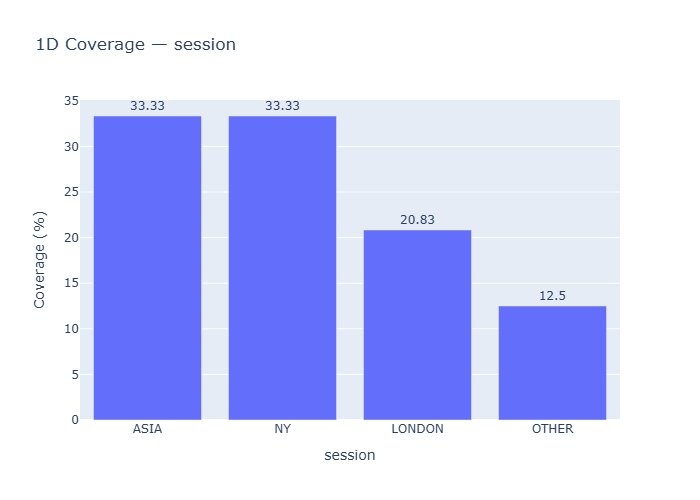

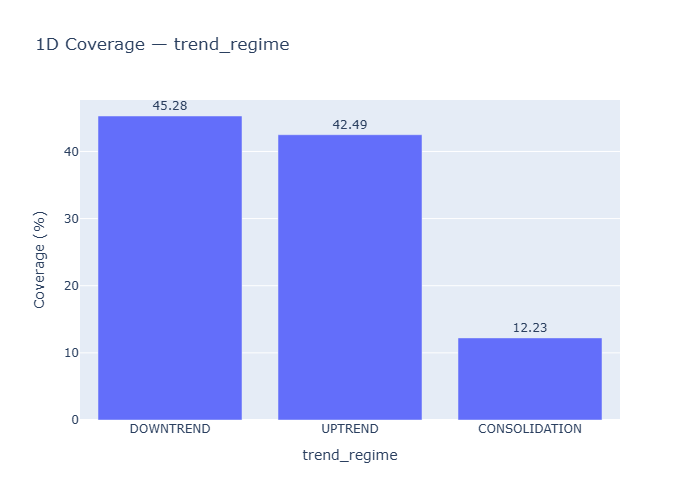

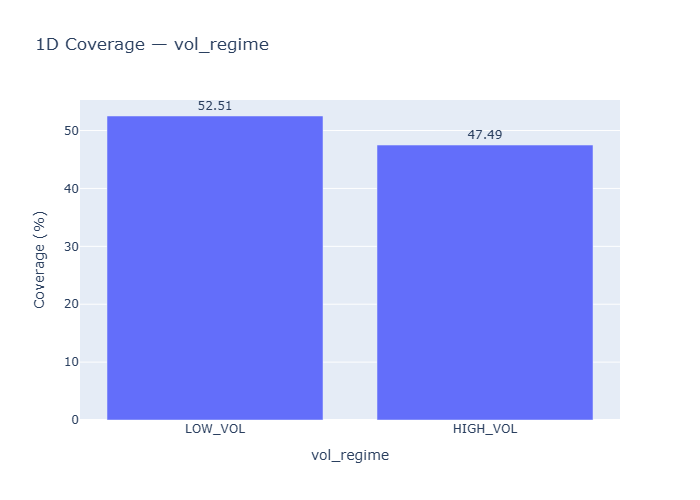

(  session bucket_key bucket_level  count  coverage_pct
 0    ASIA       ASIA           1D  12104     33.334251
 1  LONDON     LONDON           1D   7565     20.833907
 2      NY         NY           1D  12103     33.331497
 3   OTHER      OTHER           1D   4539     12.500344,
     trend_regime     bucket_key bucket_level  count  coverage_pct
 0        UPTREND        UPTREND           1D  15429     42.491256
 1      DOWNTREND      DOWNTREND           1D  16442     45.281044
 2  CONSOLIDATION  CONSOLIDATION           1D   4440     12.227700,
   vol_regime bucket_key bucket_level  count  coverage_pct
 0   HIGH_VOL   HIGH_VOL           1D  17244     47.489741
 1    LOW_VOL    LOW_VOL           1D  19067     52.510259)

In [7]:
if "px" not in globals():
    import plotly.express as px
if "coverage_table" not in globals() or "sol" not in globals():
    raise RuntimeError("Run setup/helper cells first (coverage_table + sol).")

cov_1d = {
    "session": coverage_table(sol, ["session"]),
    "trend_regime": coverage_table(sol, ["trend_regime"]),
    "vol_regime": coverage_table(sol, ["vol_regime"]),
}

for key, tbl in cov_1d.items():
    plot_tbl = tbl.sort_values("coverage_pct", ascending=False).copy()
    fig = px.bar(
        plot_tbl,
        x=key,
        y="coverage_pct",
        text=plot_tbl["coverage_pct"].round(2),
        title=f"1D Coverage — {key}",
    )
    fig.update_traces(textposition="outside")
    fig.update_layout(yaxis_title="Coverage (%)", xaxis_title=key, showlegend=False)
    fig.show()

cov_1d["session"], cov_1d["trend_regime"], cov_1d["vol_regime"]


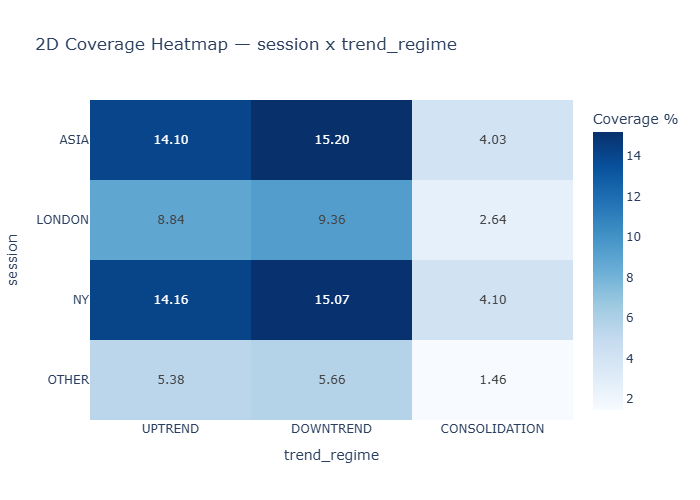

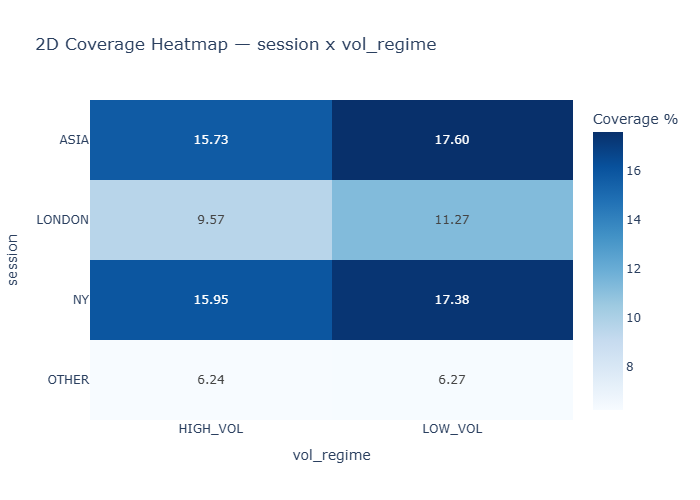

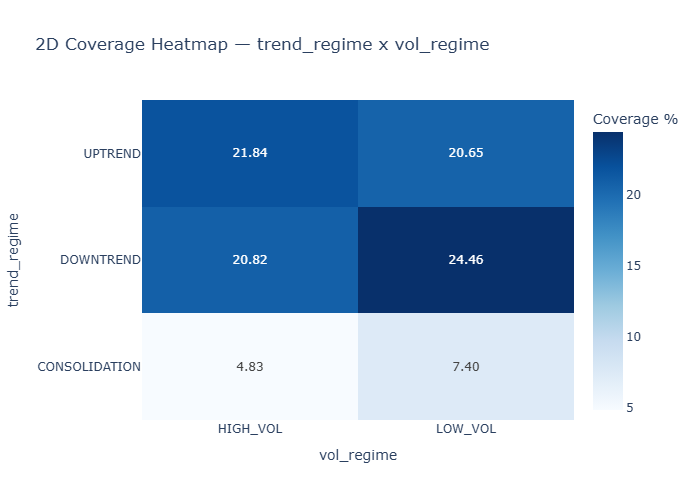

In [8]:
if "px" not in globals():
    import plotly.express as px
if "coverage_table" not in globals() or "sol" not in globals():
    raise RuntimeError("Run setup/helper cells first (coverage_table + sol).")

pairs = [
    ("session", "trend_regime"),
    ("session", "vol_regime"),
    ("trend_regime", "vol_regime"),
]

order_map = {
    "session": SESSION_ORDER,
    "trend_regime": TREND_ORDER,
    "vol_regime": VOL_ORDER,
}

for a, b in pairs:
    tbl = coverage_table(sol, [a, b])
    pivot = tbl.pivot(index=a, columns=b, values="coverage_pct").reindex(
        index=order_map.get(a, sorted(tbl[a].dropna().unique())),
        columns=order_map.get(b, sorted(tbl[b].dropna().unique())),
    ).fillna(0)

    fig = px.imshow(
        pivot,
        text_auto=".2f",
        color_continuous_scale="Blues",
        aspect="auto",
        title=f"2D Coverage Heatmap — {a} x {b}",
    )
    fig.update_layout(coloraxis_colorbar_title="Coverage %")
    fig.show()


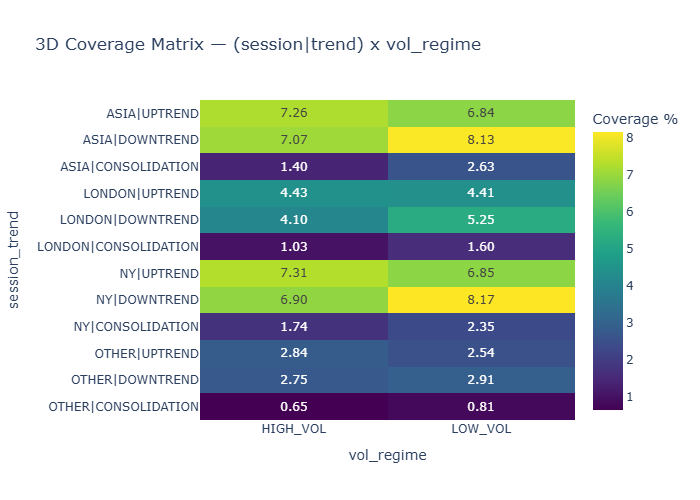

,session,trend_regime,vol_regime,bucket_key,bucket_level,count,coverage_pct,session_trend
0,NY,DOWNTREND,LOW_VOL,NY|DOWNTREND|LOW_VOL,3D,2966,8.168324,NY|DOWNTREND
1,ASIA,DOWNTREND,LOW_VOL,ASIA|DOWNTREND|LOW_VOL,3D,2952,8.129768,ASIA|DOWNTREND
2,NY,UPTREND,HIGH_VOL,NY|UPTREND|HIGH_VOL,3D,2654,7.309080,NY|UPTREND
3,ASIA,UPTREND,HIGH_VOL,ASIA|UPTREND|HIGH_VOL,3D,2637,7.262262,ASIA|UPTREND
4,ASIA,DOWNTREND,HIGH_VOL,ASIA|DOWNTREND|HIGH_VOL,3D,2566,7.066729,ASIA|DOWNTREND
5,NY,DOWNTREND,HIGH_VOL,NY|DOWNTREND|HIGH_VOL,3D,2507,6.904244,NY|DOWNTREND
6,NY,UPTREND,LOW_VOL,NY|UPTREND|LOW_VOL,3D,2489,6.854672,NY|UPTREND
7,ASIA,UPTREND,LOW_VOL,ASIA|UPTREND|LOW_VOL,3D,2484,6.840902,ASIA|UPTREND
8,LONDON,DOWNTREND,LOW_VOL,LONDON|DOWNTREND|LOW_VOL,3D,1908,5.254606,LONDON|DOWNTREND
9,LONDON,UPTREND,HIGH_VOL,LONDON|UPTREND|HIGH_VOL,3D,1610,4.433918,LONDON|UPTREND


In [9]:
if "px" not in globals():
    import plotly.express as px
if "coverage_table" not in globals() or "sol" not in globals():
    raise RuntimeError("Run setup/helper cells first (coverage_table + sol).")

cov_3d = coverage_table(sol, ["session", "trend_regime", "vol_regime"])
cov_3d["session_trend"] = cov_3d["session"] + "|" + cov_3d["trend_regime"]

row_order = [f"{s}|{t}" for s in SESSION_ORDER for t in TREND_ORDER]
heat_3d = cov_3d.pivot(index="session_trend", columns="vol_regime", values="coverage_pct").reindex(
    index=row_order,
    columns=VOL_ORDER,
).fillna(0)

fig = px.imshow(
    heat_3d,
    text_auto=".2f",
    color_continuous_scale="Viridis",
    aspect="auto",
    title="3D Coverage Matrix — (session|trend) x vol_regime",
)
fig.update_layout(coloraxis_colorbar_title="Coverage %")
fig.show()

cov_3d.sort_values("coverage_pct", ascending=False).reset_index(drop=True)


---

## D. Regime Edge (TBM Labels)

The **triple-barrier method (TBM)** evaluates every candle by simultaneously simulating a long and short trade with:
- **Take profit** at entry +/- 2.0x ATR
- **Stop loss** at entry -/+ 1.0x ATR
- **Timeout** after 24 bars (~24 hours) if neither barrier is hit

The oracle label assigned to each candle:
| Label | Meaning |
|-------|---------|
| **+1** | Long trade would have hit TP before SL |
| **-1** | Short trade would have hit TP before SL |
| **0** | Both sides timed out - no clear directional move |
| **NaN** | Whipsaw - both long and short hit their stop losses |

For each regime bucket, we compute:
- **`bias`** = P(+1) - P(-1) - positive means the bucket favors longs, negative favors shorts
- **`actionability`** = 1 - P(0) - P(NaN) - how often the bucket produces a clear directional outcome vs timeouts/whipsaws

A good candidate regime has **high |bias|**, **high actionability**, and **sufficient coverage** (sample size).

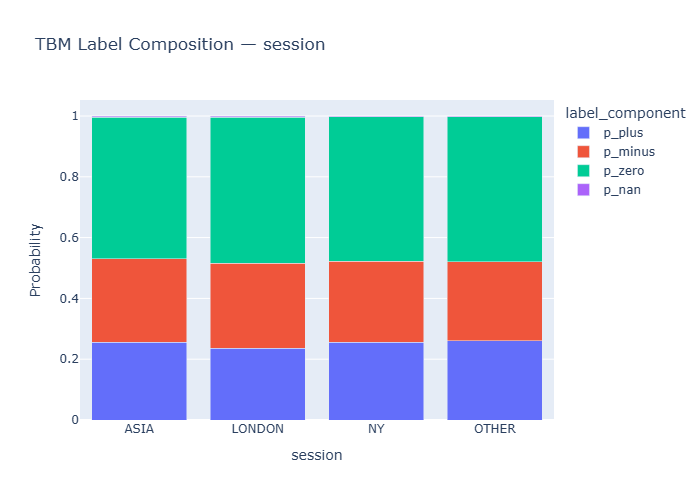

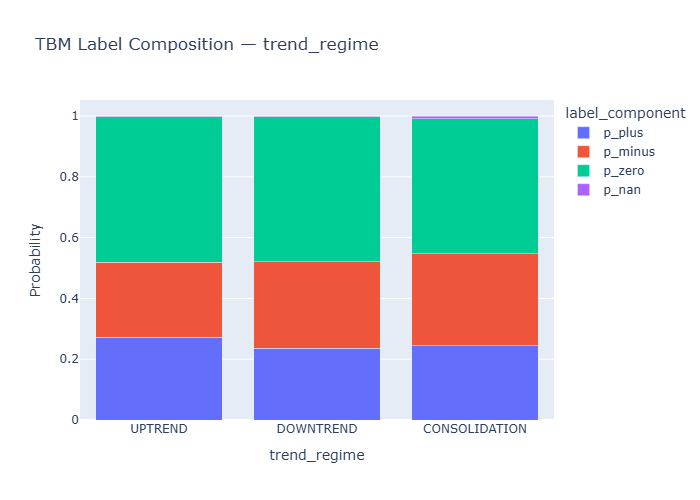

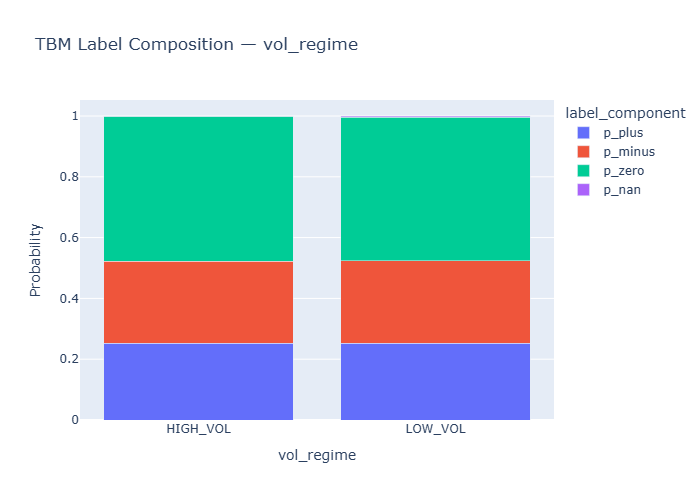

In [10]:
if "px" not in globals():
    import plotly.express as px
required = ["label_profile", "pairs", "sol"]
missing = [x for x in required if x not in globals()]
if missing:
    raise RuntimeError(f"Run prerequisite cells first. Missing: {missing}")

profile_1d = {
    "session": label_profile(sol, ["session"]),
    "trend_regime": label_profile(sol, ["trend_regime"]),
    "vol_regime": label_profile(sol, ["vol_regime"]),
}
profile_2d = {f"{a}__{b}": label_profile(sol, [a, b]) for a, b in pairs}
profile_3d = label_profile(sol, ["session", "trend_regime", "vol_regime"])

for key, tbl in profile_1d.items():
    melt = tbl[[key, "p_plus", "p_minus", "p_zero", "p_nan"]].melt(
        id_vars=[key], var_name="label_component", value_name="probability"
    )
    fig = px.bar(
        melt,
        x=key,
        y="probability",
        color="label_component",
        barmode="stack",
        title=f"TBM Label Composition — {key}",
    )
    fig.update_layout(yaxis_title="Probability")
    fig.show()


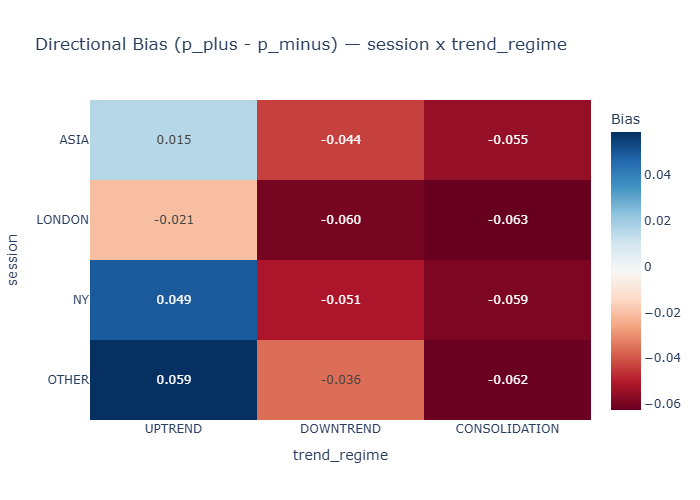

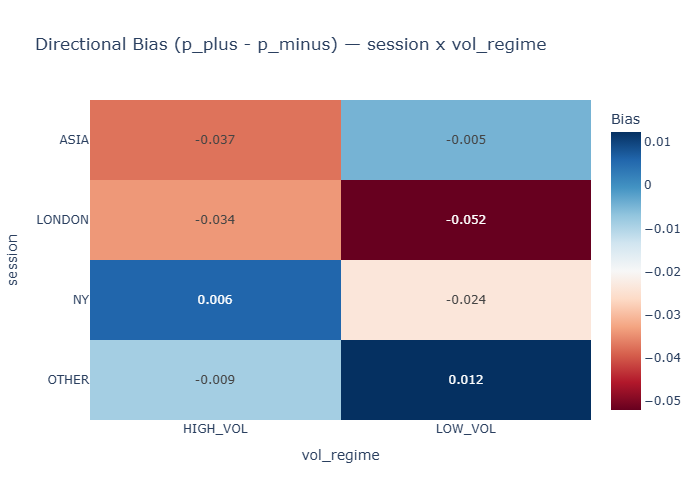

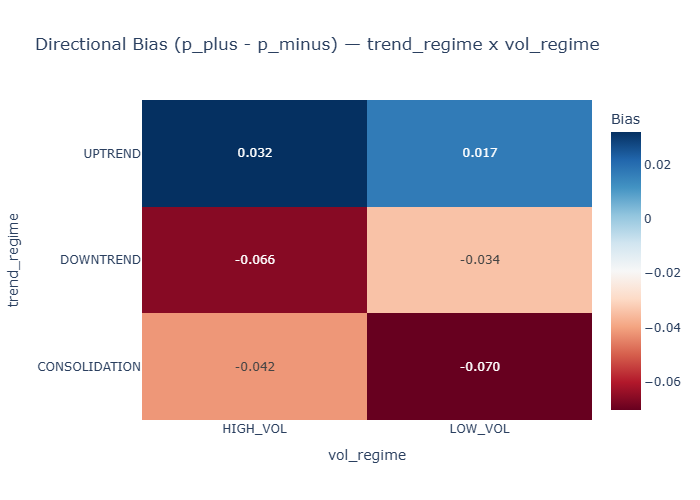

,bucket_key,count,coverage_pct,bias,actionability,p_plus,p_minus,p_zero,p_nan
17,NY|CONSOLIDATION|LOW_VOL,855,2.354658,-0.105263,0.549708,0.222222,0.327485,0.436257,0.014035
4,ASIA|CONSOLIDATION|HIGH_VOL,510,1.404533,-0.088235,0.594118,0.252941,0.341176,0.400000,0.005882
20,OTHER|DOWNTREND|HIGH_VOL,998,2.748478,-0.086172,0.519038,0.216433,0.302605,0.480962,0.000000
18,OTHER|UPTREND|HIGH_VOL,1030,2.836606,0.078641,0.529126,0.303883,0.225243,0.470874,0.000000
11,LONDON|CONSOLIDATION|LOW_VOL,582,1.602820,-0.077320,0.541237,0.231959,0.309278,0.445017,0.013746
12,NY|UPTREND|HIGH_VOL,2654,7.309080,0.068199,0.533157,0.300678,0.232479,0.465712,0.001130
2,ASIA|DOWNTREND|HIGH_VOL,2566,7.066729,-0.065861,0.517927,0.226033,0.291894,0.480514,0.001559
8,LONDON|DOWNTREND|HIGH_VOL,1489,4.100686,-0.063801,0.496306,0.216253,0.280054,0.499664,0.004030
22,OTHER|CONSOLIDATION|HIGH_VOL,236,0.649941,-0.063559,0.521186,0.228814,0.292373,0.474576,0.004237
23,OTHER|CONSOLIDATION|LOW_VOL,295,0.812426,-0.061017,0.481356,0.210169,0.271186,0.508475,0.010169


In [11]:
if "px" not in globals():
    import plotly.express as px
required = ["profile_2d", "profile_3d", "pairs"]
missing = [x for x in required if x not in globals()]
if missing:
    raise RuntimeError(f"Run prerequisite cells first. Missing: {missing}")
if "order_map" not in globals():
    order_map = {
        "session": SESSION_ORDER,
        "trend_regime": TREND_ORDER,
        "vol_regime": VOL_ORDER,
    }

for a, b in pairs:
    key = f"{a}__{b}"
    tbl = profile_2d[key]
    pivot = tbl.pivot(index=a, columns=b, values="bias").reindex(
        index=order_map.get(a, sorted(tbl[a].dropna().unique())),
        columns=order_map.get(b, sorted(tbl[b].dropna().unique())),
    )
    fig = px.imshow(
        pivot,
        text_auto=".3f",
        color_continuous_scale="RdBu",
        aspect="auto",
        title=f"Directional Bias (p_plus - p_minus) — {a} x {b}",
    )
    fig.update_layout(coloraxis_colorbar_title="Bias")
    fig.show()

profile_3d_sorted_bias = profile_3d.assign(abs_bias=profile_3d["bias"].abs()).sort_values("abs_bias", ascending=False)
profile_3d_sorted_bias[["bucket_key", "count", "coverage_pct", "bias", "actionability", "p_plus", "p_minus", "p_zero", "p_nan"]].head(24)


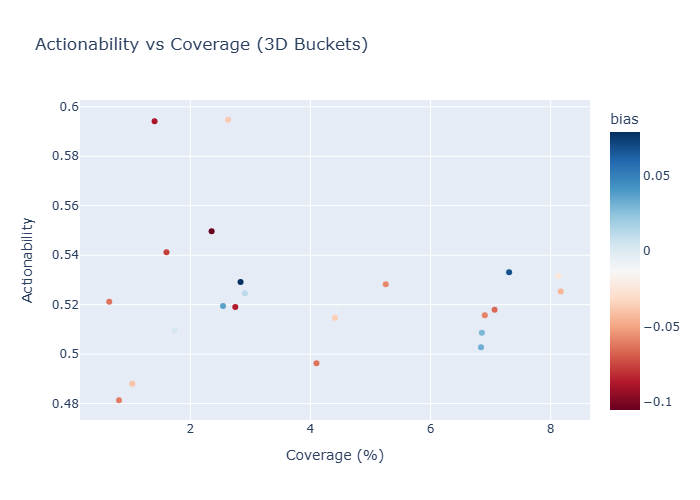

,session,trend_regime,vol_regime,bucket_key,bucket_level,count,coverage_pct,p_plus,p_minus,p_zero,p_nan,bias,actionability,prob_sum,low_count_flag
5,ASIA,CONSOLIDATION,LOW_VOL,ASIA|CONSOLIDATION|LOW_VOL,3D,955,2.630057,0.278534,0.316230,0.393717,0.011518,-0.037696,0.594764,1.0,False
4,ASIA,CONSOLIDATION,HIGH_VOL,ASIA|CONSOLIDATION|HIGH_VOL,3D,510,1.404533,0.252941,0.341176,0.400000,0.005882,-0.088235,0.594118,1.0,False
17,NY,CONSOLIDATION,LOW_VOL,NY|CONSOLIDATION|LOW_VOL,3D,855,2.354658,0.222222,0.327485,0.436257,0.014035,-0.105263,0.549708,1.0,False
11,LONDON,CONSOLIDATION,LOW_VOL,LONDON|CONSOLIDATION|LOW_VOL,3D,582,1.602820,0.231959,0.309278,0.445017,0.013746,-0.077320,0.541237,1.0,False
0,ASIA,UPTREND,HIGH_VOL,ASIA|UPTREND|HIGH_VOL,3D,2637,7.262262,0.266591,0.266591,0.466818,0.000000,0.000000,0.533182,1.0,False
12,NY,UPTREND,HIGH_VOL,NY|UPTREND|HIGH_VOL,3D,2654,7.309080,0.300678,0.232479,0.465712,0.001130,0.068199,0.533157,1.0,False
3,ASIA,DOWNTREND,LOW_VOL,ASIA|DOWNTREND|LOW_VOL,3D,2952,8.129768,0.253388,0.278117,0.464431,0.004065,-0.024729,0.531504,1.0,False
18,OTHER,UPTREND,HIGH_VOL,OTHER|UPTREND|HIGH_VOL,3D,1030,2.836606,0.303883,0.225243,0.470874,0.000000,0.078641,0.529126,1.0,False
9,LONDON,DOWNTREND,LOW_VOL,LONDON|DOWNTREND|LOW_VOL,3D,1908,5.254606,0.235325,0.292977,0.469602,0.002096,-0.057652,0.528302,1.0,False
15,NY,DOWNTREND,LOW_VOL,NY|DOWNTREND|LOW_VOL,3D,2966,8.168324,0.240391,0.284895,0.473365,0.001349,-0.044504,0.525287,1.0,False


In [12]:
if "px" not in globals():
    import plotly.express as px
if "profile_3d" not in globals():
    raise RuntimeError("Run label-profile cells first (profile_3d is missing).")

LOW_COUNT_THRESHOLD = max(30, int(len(sol) * 0.002))

act_tbl = profile_3d.copy()
act_tbl["low_count_flag"] = act_tbl["count"] < LOW_COUNT_THRESHOLD

fig = px.scatter(
    act_tbl,
    x="coverage_pct",
    y="actionability",
    color="bias",
    hover_data=["bucket_key", "count", "p_plus", "p_minus", "p_zero", "p_nan", "low_count_flag"],
    title="Actionability vs Coverage (3D Buckets)",
    color_continuous_scale="RdBu",
)
fig.update_layout(xaxis_title="Coverage (%)", yaxis_title="Actionability")
fig.show()

act_tbl.sort_values(["actionability", "coverage_pct"], ascending=[False, False]).head(24)


---

## E. Temporal Drift

A regime edge is only useful if it persists over time. This section checks:

1. **Regime distribution drift** - Do the proportions of UPTREND/DOWNTREND/CONSOLIDATION (and other dimensions) stay stable month-to-month, or do they shift dramatically? Large shifts mean the market's character is changing.
2. **Bias drift for top buckets** - For the highest-coverage and highest-bias 3D buckets, track monthly directional bias. A bucket that flips sign frequently is unreliable regardless of its aggregate statistics.

C:\Users\a.pattichis\AppData\Local\Temp\ipykernel_51592\2065646821.py:123: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



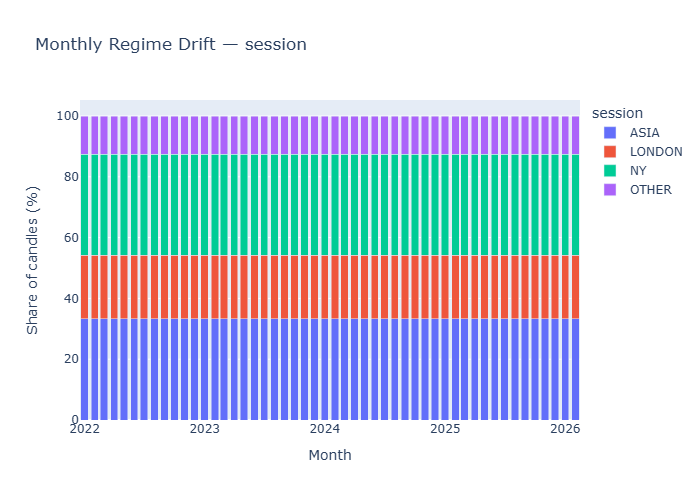

C:\Users\a.pattichis\AppData\Local\Temp\ipykernel_51592\2065646821.py:123: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



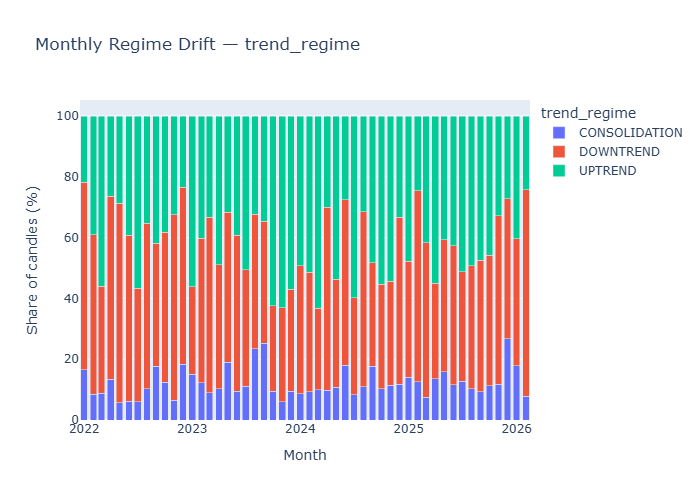

C:\Users\a.pattichis\AppData\Local\Temp\ipykernel_51592\2065646821.py:123: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



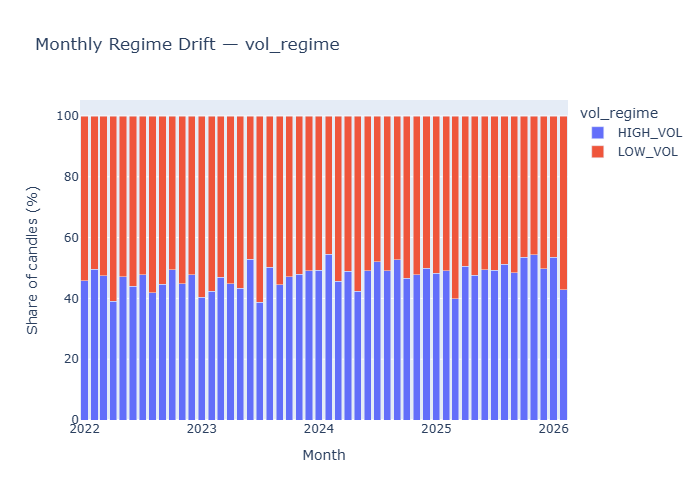

In [13]:
if "px" not in globals():
    import plotly.express as px
if "monthly_regime_drift" not in globals() or "sol" not in globals():
    raise RuntimeError("Run setup/helper cells first (monthly_regime_drift + sol).")

for col in ["session", "trend_regime", "vol_regime"]:
    drift = monthly_regime_drift(sol, col)
    fig = px.bar(
        drift,
        x="month",
        y="pct",
        color=col,
        barmode="stack",
        title=f"Monthly Regime Drift — {col}",
    )
    fig.update_layout(yaxis_title="Share of candles (%)", xaxis_title="Month")
    fig.show()


C:\Users\a.pattichis\AppData\Local\Temp\ipykernel_51592\3494610349.py:13: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



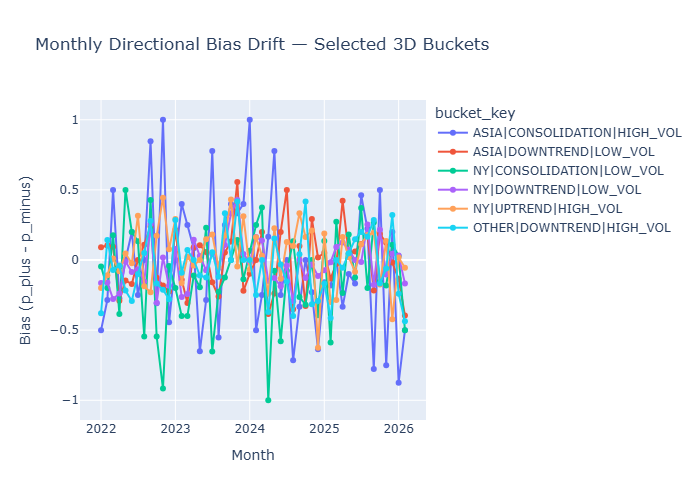

,month,bucket_key,bias
0,2022-01,ASIA|CONSOLIDATION|HIGH_VOL,-0.500000
1,2022-01,ASIA|DOWNTREND|LOW_VOL,0.090909
2,2022-01,NY|CONSOLIDATION|LOW_VOL,-0.045455
3,2022-01,NY|DOWNTREND|LOW_VOL,-0.163934
4,2022-01,NY|UPTREND|HIGH_VOL,-0.200000
...,...,...,...
295,2026-02,ASIA|DOWNTREND|LOW_VOL,-0.396552
296,2026-02,NY|CONSOLIDATION|LOW_VOL,-0.500000
297,2026-02,NY|DOWNTREND|LOW_VOL,-0.166667
298,2026-02,NY|UPTREND|HIGH_VOL,-0.055556


In [14]:
if "px" not in globals():
    import plotly.express as px
required = ["profile_3d", "bucket_key_from_dims", "sol"]
missing = [x for x in required if x not in globals()]
if missing:
    raise RuntimeError(f"Run prerequisite cells first. Missing: {missing}")

top_by_coverage = profile_3d.nlargest(3, "coverage_pct")["bucket_key"].tolist()
top_by_abs_bias = profile_3d.assign(abs_bias=profile_3d["bias"].abs()).nlargest(3, "abs_bias")["bucket_key"].tolist()
selected_keys = list(dict.fromkeys(top_by_coverage + top_by_abs_bias))

tmp = sol.copy()
tmp["month"] = tmp.index.to_period("M").astype(str)
tmp["bucket_key"] = bucket_key_from_dims(tmp, ["session", "trend_regime", "vol_regime"])

monthly_bias = (
    tmp[tmp["bucket_key"].isin(selected_keys)]
    .groupby(["month", "bucket_key"])["tbm_label"]
    .apply(lambda s: (s == 1).mean() - (s == -1).mean())
    .rename("bias")
    .reset_index()
)

fig = px.line(
    monthly_bias,
    x="month",
    y="bias",
    color="bucket_key",
    markers=True,
    title="Monthly Directional Bias Drift — Selected 3D Buckets",
)
fig.update_layout(yaxis_title="Bias (p_plus - p_minus)", xaxis_title="Month")
fig.show()

monthly_bias


---

## F. Validation and Consolidated Findings

Automated consistency checks to catch pipeline bugs or data corruption:

1. Schema, index, and label integrity (via `validate_state_matrix`)
2. Coverage counts sum to total rows at every grouping level
3. Label probabilities (p_plus + p_minus + p_zero + p_nan) sum to 1.0 in every bucket
4. Monthly drift computation returns non-empty results
5. All 24 expected 3D buckets are populated (no zero-count gaps)

The **findings table** consolidates all 1D, 2D, and 3D bucket profiles with automated commentary flagging the best candidates, weak edges, and low-sample warnings.

In [15]:
# 1) Schema test + 2) Index test + 3) Label integrity test
_ = validate_state_matrix(sol)

# 4) Coverage consistency test for grouped buckets
for dims in [["session"], ["session", "trend_regime"], ["session", "trend_regime", "vol_regime"]]:
    ct = coverage_table(sol, dims)
    assert int(ct["count"].sum()) == len(sol), f"Coverage count mismatch for {dims}"

# 5) Probability consistency test
for prof, name in [
    (profile_1d["session"], "1D session"),
    (profile_1d["trend_regime"], "1D trend"),
    (profile_1d["vol_regime"], "1D vol"),
    (profile_3d, "3D"),
]:
    assert np.allclose(prof["prob_sum"].values, 1.0, atol=1e-8), f"Probability sum mismatch in {name}"

# 6) Drift section test
drift_test = monthly_regime_drift(sol, "session")
assert len(drift_test) > 0, "Monthly drift computation returned empty output"

# 7) Empty bucket safety check
all_3d = pd.MultiIndex.from_product([SESSION_ORDER, TREND_ORDER, VOL_ORDER], names=["session", "trend_regime", "vol_regime"])
observed = profile_3d.set_index(["session", "trend_regime", "vol_regime"]) ["count"]
reindexed = observed.reindex(all_3d, fill_value=0)
print("Validation checks passed.")
print(f"3D buckets with zero observed candles: {(reindexed == 0).sum()}")
print(f"Low count threshold used for warnings: {LOW_COUNT_THRESHOLD}")


Validation checks passed.
3D buckets with zero observed candles: 0
Low count threshold used for warnings: 72


C:\Users\a.pattichis\AppData\Local\Temp\ipykernel_51592\2065646821.py:123: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [16]:
findings = build_findings_table(
    profile_1d=pd.concat(profile_1d.values(), ignore_index=True),
    profile_2d=pd.concat(profile_2d.values(), ignore_index=True),
    profile_3d=profile_3d,
    low_count_threshold=LOW_COUNT_THRESHOLD,
)

findings.head(60)


,bucket_level,bucket_key,count,coverage_pct,bias,actionability,p_plus,p_minus,p_zero,p_nan,low_count_flag,comment
0,1D,LOW_VOL,19067,52.510259,-0.019143,0.524624,0.252740,0.271883,0.470709,0.004668,False,Neutral edge: weak directional skew.
1,1D,HIGH_VOL,17244,47.489741,-0.018441,0.522501,0.252030,0.270471,0.476398,0.001102,False,Neutral edge: weak directional skew.
2,1D,DOWNTREND,16442,45.281044,-0.048778,0.521104,0.236163,0.284941,0.476584,0.002311,False,Potentially useful; validate with strategy-spe...
3,1D,UPTREND,15429,42.491256,0.024694,0.519736,0.272215,0.247521,0.478190,0.002074,False,Potentially useful; validate with strategy-spe...
4,1D,ASIA,12104,33.334251,-0.020159,0.530734,0.255288,0.275446,0.465962,0.003305,False,Potentially useful; validate with strategy-spe...
5,1D,NY,12103,33.331497,-0.009584,0.522515,0.256465,0.266050,0.474841,0.002644,False,Neutral edge: weak directional skew.
6,1D,LONDON,7565,20.833907,-0.043754,0.515929,0.236087,0.279841,0.480767,0.003305,False,Potentially useful; validate with strategy-spe...
7,1D,OTHER,4539,12.500344,0.001763,0.520379,0.261071,0.259308,0.477198,0.002423,False,Neutral edge: weak directional skew.
8,1D,CONSOLIDATION,4440,12.227700,-0.059009,0.546396,0.243694,0.302703,0.445045,0.008559,False,Potentially useful; validate with strategy-spe...
9,2D,DOWNTREND|LOW_VOL,8882,24.460907,-0.034114,0.527922,0.246904,0.281018,0.469151,0.002927,False,Potentially useful; validate with strategy-spe...


---

### How to Read the Findings Table

Each row is a regime bucket scored on three axes:

| Metric | What it tells you |
|--------|-------------------|
| **coverage_pct** | Sample size as % of total candles - higher is more reliable |
| **bias** | Directional skew - positive favors longs, negative favors shorts |
| **actionability** | How often the bucket produces a tradeable outcome (not timeout/whipsaw) |

**Automated commentary rules:**
- "Good candidate regime" - |bias| >= 0.08, actionability >= 0.50, coverage >= 3%
- "Neutral edge" - |bias| < 0.02 regardless of other metrics
- "Avoid/uncertain" - actionability < 0.25 (mostly timeouts)
- "Uncertain: low sample" - below the low-count threshold (0.2% of total rows)

Buckets that look good here should be validated in the temporal drift section (Section E) to confirm the edge is stable, then tested with actual strategy-specific backtests.